# Preprocessing

In this excercise, we will focus on several preprocessing steps, including smoothing, gap filling, outlier removal, and modifying the time series' cadence. 


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### **Plot time series**

We'll first load and plot the raw time series that we'll use in the exercise. The time series consists of LAI data derived from Sentinel-2 over a forested area. As shown in the plot below, the time series is rather noisy and contains several negative spikes that likely result from remaining atmospheric or cloud artifacts.

           Date  forest - Sentinel 2 - LAI
0    06-07-2015                       3.32
1    16-07-2015                       3.24
2    02-08-2015                       3.16
3    05-08-2015                       2.76
4    12-08-2015                       1.67
..          ...                        ...
241  09-10-2021                       2.26
242  24-10-2021                       2.02
243  27-10-2021                       1.28
244  29-10-2021                       1.40
245  01-11-2021                       1.00

[246 rows x 2 columns]


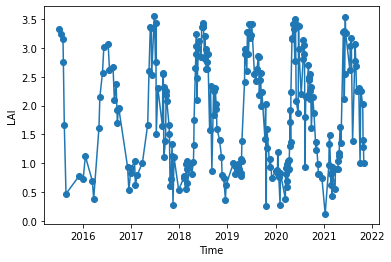

In [3]:
# Let's first load the data
# Import the time series as a pandas dataframe
dat = pd.read_csv('./data/B_preprocessing/forest_senLAI.csv')

#Let's have a look at the dataset
print(dat)

# let's plot the time series
x = [datetime.strptime(x, '%d-%m-%Y') for x in dat['Date']]
y = dat['forest - Sentinel 2 - LAI']

plt.plot(x,y,'o-') # the 'o-' indicates that both point markers as well as lines should be plotted
plt.xlabel('Time') # this sets the x label
plt.ylabel('LAI') # this sets the y label
plt.show()

dat['Date'] = pd.to_datetime(dat['Date'], format='%d-%m-%Y')


### **Outlier removal**

Remaining effects of residual clouds or atmospheric constituents may introduce outliers in the time series. These are often present as negetive spikes. Because these outliers may affect the analysis a lot, it can be desired to filter them out.

We'll first smooth the time series using a rolling median filter and subsequently exclude observations that deviate more than a user defined threshold from the raw time series. The threshold is here defined as *n* (= *user_factor* in the code below) times the standard deviation of the time series.



> Generated roll window size is: 5


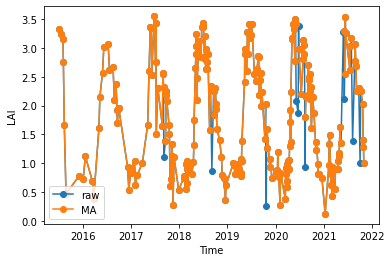

In [4]:
# define user factor that regulates the outlier threshold
user_factor =1

# specify the moving window size of the rolling median 
win_size = int(len(dat) / 7)
win_size = int(win_size / int(len(dat.resample('1Y', on='Date').mean())))

if win_size < 3:
    win_size = 3
    print('> Generated roll window size less than 3, setting to default (3).')
elif win_size % 2 == 0:
    win_size = win_size + 1
    print('> Generated roll window size is an even number, added 1 to make it odd ({0}).'.format(win_size))
else:
    print('> Generated roll window size is: {0}'.format(win_size))


# the cutoff value is here speficied as the standard deviation times a user factor
cutoffs = dat['forest - Sentinel 2 - LAI'].std() * user_factor

# calculate the rolling median 
ds_med = dat['forest - Sentinel 2 - LAI'].rolling(win_size, center=True).median()

# calculate the absolute difference between original time series and smoothed (median filter) time series
ds_diffs = abs(dat['forest - Sentinel 2 - LAI'].values - ds_med)

# calculate the mask of outliers where absolute differences exceed cutoff value
outlier_mask = ds_diffs > cutoffs

# mask the time series
dat_mask = dat['forest - Sentinel 2 - LAI'].copy()
dat_mask[outlier_mask] = np.nan
y8 = dat_mask

# plot the time series before and after outlier removal
plt.plot(x,y,'o-') 
plt.plot(x,y8,'o-')  
plt.xlabel('Time')
plt.ylabel('LAI') 
plt.legend(['raw','MA'])
plt.show()

**Question**: Try to change the user_factor when filtering outliers. Do you detect more or less outliers? Why?

### **Changing the cadence of a time series**

Another preprocessing step that can be taken is to change the temporal cadence of the time series. This can for instance be achieved by taking the mean or median value over predefined time steps (in this case one month). Although some temporal information may be lost, the time series looks much smoother. In addition, the time series has regular time steps, which is often a requirement for other processing algorithms. 

Here, we'll illustrate the use of mean and median value composites. For each month, all observations that are covered by that month are averaged to produce the composited value of that month. Note, that composites can also be calculated by using other functions (e.g. maximum value) or by using other time periods.

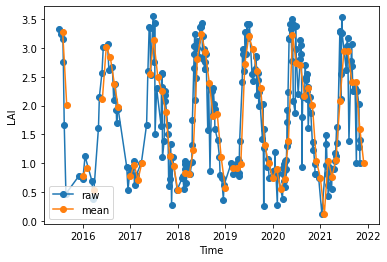

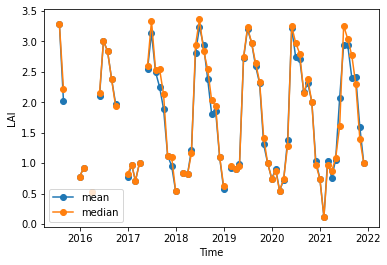

In [6]:
dat_res_mean = dat.resample('1M', on='Date').mean()
dat_res_median = dat.resample('1M', on='Date').median()


# let's plot the time series
x2 = dat_res_mean.index 
y2 = dat_res_mean['forest - Sentinel 2 - LAI']

x3 = dat_res_median.index 
y3 = dat_res_median['forest - Sentinel 2 - LAI']

plt.plot(x,y,'o-')  
plt.plot(x2,y2,'o-') 
plt.xlabel('Time')
plt.ylabel('LAI') 
plt.legend(['raw', 'mean'])
plt.show()

plt.plot(x2,y2,'o-') 
plt.plot(x3,y3,'o-') 
plt.xlabel('Time') 
plt.ylabel('LAI') 
plt.legend(['mean', 'median'])
plt.show()

**Question**: Try to calculate a maximum value composite over periods of two months

### **Gap filling**

The removal of outliers introduces missing observations. To fill these, a series of gap filling algorithms can be used. We'll show here the use of linear interpolation to fill gaps. 


Please note that the interpolation function also contains other methods to fill gaps, such as nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘spline’, ‘barycentric’, and ‘polynomial’. The following link provides more information about the interpolation methods: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html.

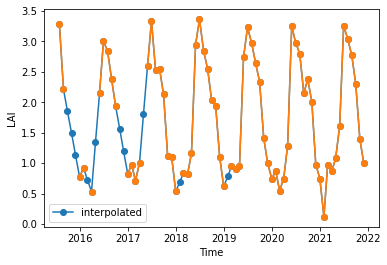

In [19]:
# linear interpolation

dat_int_lin = dat_res_median.interpolate(method='linear')

# let's plot the result! 
# We'll plot the time series before and after gap filling
x4 = dat_int_lin.index 
y4 = dat_int_lin['forest - Sentinel 2 - LAI']

plt.plot(x4,y4,'o-') 
plt.plot(x3,y3,'o-')  
plt.xlabel('Time')
plt.ylabel('LAI') 
plt.legend(['interpolated'])
plt.show()

**Question**: Try to fill gaps using a cubic interpolation method. Does the result differ a lot from linear interpolation?



### **Smoothing and function fitting**

Finally, residual noise can be reduced using smoothing or function fitting methods. These methods are often also capable to fill gaps. Here, we will apply a moving average and a Savitzky Golay filter. The moving average filter takes the first *n* observations of a time series, computes their mean, and assigns the mean value to the last observation. This is repeated using the following *n* observations until the last observation of the time series has been reached. The Savitzky Golay filter¨also works with a moving window approach. It fits a polynomial function within the data of a moving window and uses the fitted value to produce a filtered time series.

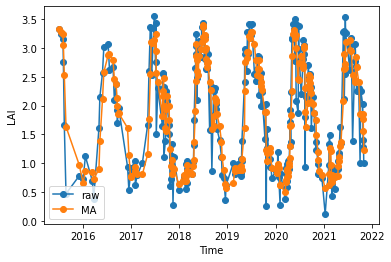

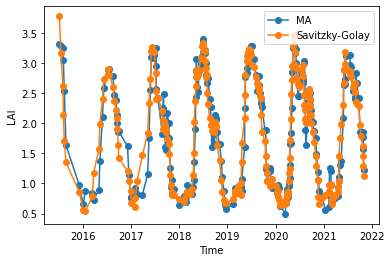

In [27]:
from scipy.signal import savgol_filter

# moving average filter
dat_ma = dat.rolling(3, min_periods=1).mean()

x6 = dat_ma.index 
y6 = dat_ma['forest - Sentinel 2 - LAI']

# plot time series before and after filtering
plt.plot(x,y,'o-') 
plt.plot(x,y6,'o-')  
plt.xlabel('Time')
plt.ylabel('LAI') 
plt.legend(['raw','MA'])
plt.show()


# savitsky golay filter
dat_sg = dat.transform(lambda x: savgol_filter(x, 11,2)) # window size of 11 and order 2

x5 = dat_sg.index 
y5 = dat_sg['forest - Sentinel 2 - LAI']

# compare the result of the moving average and savitzky-golay filter
plt.plot(x,y6,'o-') 
plt.plot(x,y5,'o-')  
plt.xlabel('Time')
plt.ylabel('LAI') 
plt.legend(['MA','Savitzky-Golay'])
plt.show()




**Question**: What is the effect of increasing the window size of the moving average and Savitzky golay filter? And the order? Try it out!